<a href="https://colab.research.google.com/github/CristianCosci/interpolationStudy_toHandleMissingData_BTCdataset/blob/main/interpolazione.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import pandas as pd
from tqdm import *  #libreria per barre di progressione
import matplotlib.pyplot as plt
import os
import requests
import numpy as np
from sklearn.metrics import r2_score

In [37]:
def generateBitcoinOHLCV(exchange, compression):
    """
    Download exchange data from bitcoincharts.com and building OHLCV candelsticks format

    Parameters
    ----------
    exchange : str
        Exchange's name from http://api.bitcoincharts.com/v1/csv/

    compression : int
      minutes for resampling  

    Returns
    -------
    historicalOHLCV : pd.DataFrame
        Dataframe with historical OHLCV candlesticks
    """

    bitcoinchartsUrl = "http://api.bitcoincharts.com/v1/csv/{}USD.csv.gz".format(exchange)    #data in USD currency

    print("Downloading {} trade data from URL {}".format(exchange, bitcoinchartsUrl))
    print()

    historicalTrades = pd.read_csv(bitcoinchartsUrl, names=["unixtime", "price", "amount"], compression='gzip')   #reading csv from url
    """
    Il csv presenta i dati relativi agli scambi sull'exchange.
    
    Formato dei dati (preso direttamente dal sito https://bitcoincharts.com/about/markets-api/):
        
        HISTORICAL TRADE DATA

        returns CSV:

        unixtime,price,amount
    """

    historicalTrades["datetime"] = pd.to_datetime(historicalTrades["unixtime"], unit="s") #conversion timestamp to datetime
    historicalTrades = historicalTrades.drop("unixtime", axis=1).set_index("datetime").sort_index()
    historicalTrades = historicalTrades[~(historicalTrades.index < '2012-01-01 00:00:00')] #put the data starts to 2012

    historicalOHLCV = historicalTrades

    #build OHLCV historical data
    historicalOHLCV["open"] = historicalTrades["price"]
    historicalOHLCV["high"] = historicalTrades["price"]
    historicalOHLCV["low"] = historicalTrades["price"]
    historicalOHLCV["close"] = historicalTrades["price"]
    historicalOHLCV["volume"] = historicalTrades["amount"]

    historicalOHLCV = historicalOHLCV.drop(["price", "amount"], axis=1)

    historicalOHLCV = historicalOHLCV.resample(str(compression) + "min").agg({"open": "first", "high": "max", "low": "min", "close": "last", "volume": "sum"})
    #historicalOHLCV = historicalOHLCV.resample(str(compression) + "min").agg({"open": "first", "high": "max", "low": "min", "close": "last", "volume": "sum"}).dropna()
    return historicalOHLCV[["open", "high", "low", "close", "volume"]]

In [38]:
def resumeNaN(dfname, df):
  """
  Print the NaN rows for the df

  Parameters
    ----------
    dfname : string
      Exchange's name

    df : pd.DataFrame
      data to analize
  """
  is_NaN = df.isnull()
  row_has_NaN = is_NaN.any(axis=1)
  rows_with_NaN = df[row_has_NaN]
  print()
  print("exchange: {}".format(dfname))
  print("----------------------")
  print(rows_with_NaN)
  print()
  print("----------------------")

In [39]:
def creaCartelle():
  if(os.path.isdir("/home/csv")  == False and len("/home/csv")>0):
    os.makedirs("/home/csv")

In [40]:
creaCartelle()

# Define the compression and the output file
compression = 60 #min
outputFile = ""

# Define the exchanges we want to aggregate
exchanges = ["bitstamp"]

OHLCV = {}

for exchange in tqdm(exchanges):
  OHLCV[exchange] = generateBitcoinOHLCV(exchange, compression)
  outputFile = "{}_data.csv".format(exchange)
  print("Saving {} rows to file {}".format(len(OHLCV), outputFile))
  print()
  OHLCV[exchange].to_csv("/home/csv/{}".format(outputFile))


  0%|          | 0/1 [00:00<?, ?it/s]


Saving 1 rows to file bitstamp_data.csv



100%|██████████| 1/1 [01:08<00:00, 68.68s/it]


In [41]:
#Create new DataFrame to analize with only the interval choosed
df = pd.DataFrame()
df["open"] = OHLCV["bitstamp"]["open"].loc['2014-02-02 11:00:00':'2014-07-11 04:00:00'] #get an interval without NaN
print(df)

                       open
datetime                   
2014-02-02 11:00:00  824.50
2014-02-02 12:00:00  819.40
2014-02-02 13:00:00  822.00
2014-02-02 14:00:00  821.98
2014-02-02 15:00:00  818.34
...                     ...
2014-07-11 00:00:00  616.87
2014-07-11 01:00:00  616.58
2014-07-11 02:00:00  617.00
2014-07-11 03:00:00  619.18
2014-07-11 04:00:00  619.79

[3810 rows x 1 columns]


In [42]:
#Generate NaN
nan_mat = np.random.random(df.shape)<0.25 #0.25% of NaN
print("NaN generated: ",nan_mat.sum()) #number of NaN generated

df_NaN = df.mask(nan_mat) #new DataFrame with nan
print(df_NaN)

resumeNaN("bistamp interval", df_NaN)

NaN generated:  963
                       open
datetime                   
2014-02-02 11:00:00  824.50
2014-02-02 12:00:00  819.40
2014-02-02 13:00:00  822.00
2014-02-02 14:00:00     NaN
2014-02-02 15:00:00  818.34
...                     ...
2014-07-11 00:00:00     NaN
2014-07-11 01:00:00  616.58
2014-07-11 02:00:00  617.00
2014-07-11 03:00:00     NaN
2014-07-11 04:00:00  619.79

[3810 rows x 1 columns]

exchange: bistamp interval
----------------------
                     open
datetime                 
2014-02-02 14:00:00   NaN
2014-02-02 17:00:00   NaN
2014-02-03 01:00:00   NaN
2014-02-03 03:00:00   NaN
2014-02-03 05:00:00   NaN
...                   ...
2014-07-10 17:00:00   NaN
2014-07-10 22:00:00   NaN
2014-07-10 23:00:00   NaN
2014-07-11 00:00:00   NaN
2014-07-11 03:00:00   NaN

[963 rows x 1 columns]

----------------------


In [43]:
#Create new column to better score the interpolate methods
df["reference"] = df["open"]
df["target"] = df_NaN["open"]
df = df.drop("open", axis=1)
print(df)

                     reference  target
datetime                              
2014-02-02 11:00:00     824.50  824.50
2014-02-02 12:00:00     819.40  819.40
2014-02-02 13:00:00     822.00  822.00
2014-02-02 14:00:00     821.98     NaN
2014-02-02 15:00:00     818.34  818.34
...                        ...     ...
2014-07-11 00:00:00     616.87     NaN
2014-07-11 01:00:00     616.58  616.58
2014-07-11 02:00:00     617.00  617.00
2014-07-11 03:00:00     619.18     NaN
2014-07-11 04:00:00     619.79  619.79

[3810 rows x 2 columns]


In [44]:
df = df.assign(missing= np.nan) #create new column with missing values
df.missing[df.target.isna()] = df.reference
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3810 entries, 2014-02-02 11:00:00 to 2014-07-11 04:00:00
Freq: 60T
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   reference  3810 non-null   float64
 1   target     2847 non-null   float64
 2   missing    963 non-null    float64
dtypes: float64(3)
memory usage: 119.1 KB


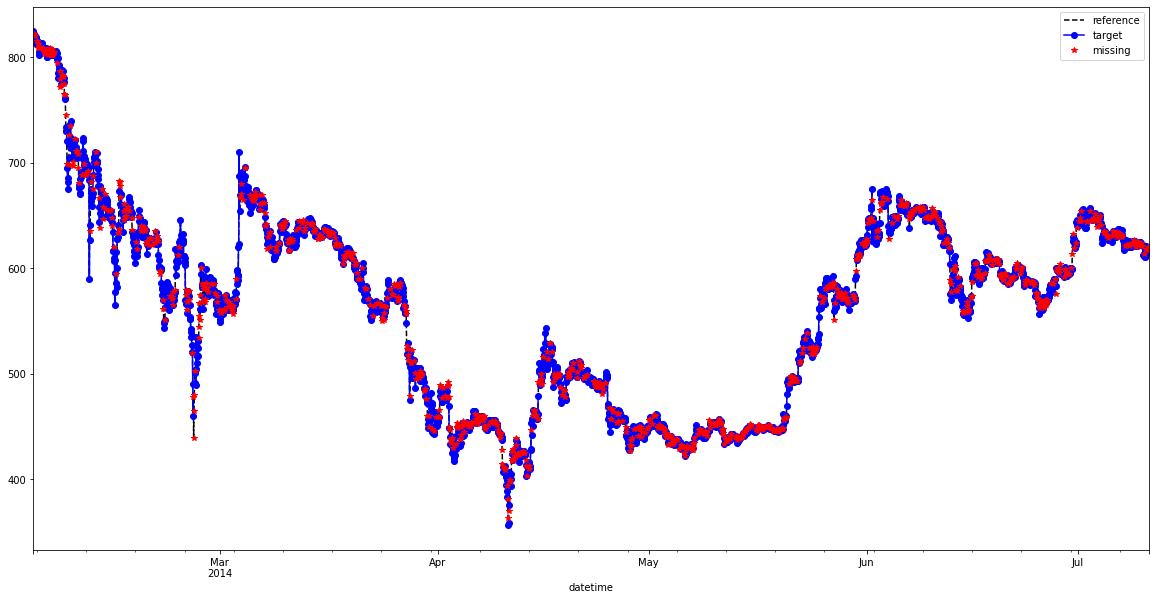

In [45]:
df.plot(style=['k--', 'bo-', 'r*'], figsize=(20, 10))

In [46]:
#INTERPOLATE METHODS 
df = df.assign(FillMean=df.target.fillna(df.target.mean()))
df = df.assign(FillMedian=df.target.fillna(df.target.median()))
df = df.assign(RollingMean=df.target.fillna(df.target.rolling(24,min_periods=1,).mean()))
df = df.assign(RollingMedian=df.target.fillna(df.target.rolling(24,min_periods=1,).median()))
df = df.assign(InterpolateLinear=df.target.interpolate(method='linear'))
df = df.assign(InterpolateTime=df.target.interpolate(method='time'))
df = df.assign(InterpolateQuadratic=df.target.interpolate(method='quadratic'))
df = df.assign(InterpolateCubic=df.target.interpolate(method='cubic'))
df = df.assign(InterpolateSLinear=df.target.interpolate(method='slinear'))
df = df.assign(InterpolateAkima=df.target.interpolate(method='akima'))
df = df.assign(InterpolatePoly5=df.target.interpolate(method='polynomial', order=5)) 
df = df.assign(InterpolatePoly7=df.target.interpolate(method='polynomial', order=7))
df = df.assign(InterpolateSpline3=df.target.interpolate(method='spline', order=3))
df = df.assign(InterpolateSpline4=df.target.interpolate(method='spline', order=4))
df = df.assign(InterpolateSpline5=df.target.interpolate(method='spline', order=5))

In [47]:
#EVALUTE EACH INTERPOLATE METHODS TO SEE WHICH IS BETTER IN THIS EXAMPLE CASE
results = [(method, r2_score(df.reference, df[method])) for method in list(df)[3:]]
results_df = pd.DataFrame(np.array(results), columns=['Method', 'R_squared'])
results_df.sort_values(by='R_squared', ascending=False)

,Method,R_squared
4,InterpolateLinear,0.9994426781764747
5,InterpolateTime,0.9994426781764747
8,InterpolateSLinear,0.9994426781764747
9,InterpolateAkima,0.9994239345857749
12,InterpolateSpline3,0.9992934112602558
6,InterpolateQuadratic,0.9992738022991622
7,InterpolateCubic,0.9992374285971733
14,InterpolateSpline5,0.998949939973523
10,InterpolatePoly5,0.9987611159012985
11,InterpolatePoly7,0.9979553201389362
